In [2]:
import pandas as pd

df_fear_greed = pd.read_csv("/content/fear_greed_index.csv")
df_historical_data = pd.read_csv("/content/historical_data.csv")

In [3]:
df_fear_greed.sample(n=5)
df_fear_greed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [5]:
df_historical_data.sample(n=5)
df_historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [6]:
df_historical_data['Timestamp IST'] = pd.to_datetime(df_historical_data["Timestamp IST"], format="%d-%m-%Y %H:%M")
df_historical_data['date'] = df_historical_data['Timestamp IST'].dt.date

df_historical_data['Timestamp IST'].dt.year.unique()

df_fear_greed['date'] = pd.to_datetime(df_fear_greed['date'])

df_fear_greed = df_fear_greed[
    df_fear_greed['date'].dt.year.isin([2023, 2024, 2025])
]

df_fear_greed

,timestamp,value,classification,date
1792,1672551000,26,Fear,2023-01-01
1793,1672637400,27,Fear,2023-01-02
1794,1672723800,26,Fear,2023-01-03
1795,1672810200,29,Fear,2023-01-04
1796,1672896600,29,Fear,2023-01-05
...,...,...,...,...
2639,1745818200,54,Neutral,2025-04-28
2640,1745904600,60,Greed,2025-04-29
2641,1745991000,56,Greed,2025-04-30
2642,1746077400,53,Neutral,2025-05-01


In [7]:
df_historical_data['Closed PnL'] = pd.to_numeric(df_historical_data['Closed PnL'])
df_historical_data['Size USD'] = pd.to_numeric(df_historical_data['Size USD'])

daily_trade_summary = df_historical_data.groupby('date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Account': 'nunique'
}).reset_index().rename(columns={
    'Closed PnL': 'total_pnl',
    'Size USD': 'total_volume_usd',
    'Account': 'unique_traders'
})

daily_trade_summary.sample(n=5)

,date,total_pnl,total_volume_usd,unique_traders
131,2024-05-05,0.916000,24068.35,2
478,2025-04-30,14003.797269,12693878.85,8
397,2025-02-08,586.703253,839734.97,10
336,2024-12-09,6310.967676,983949.68,10
202,2024-07-18,3803.884311,649704.85,2


In [8]:
df_fear_greed['date'] = pd.to_datetime(df_fear_greed['date']).dt.date

performance_and_market_sentiment_merged_df = pd.merge(daily_trade_summary, df_fear_greed[['date', 'value', 'classification']], on='date', how='left')

performance_and_market_sentiment_merged_df

,date,total_pnl,total_volume_usd,unique_traders,value,classification
0,2023-05-01,0.000000,477.00,1,63.0,Greed
1,2023-12-05,0.000000,50005.83,1,75.0,Extreme Greed
2,2023-12-14,-205.434737,113203.35,1,72.0,Greed
3,2023-12-15,-24.632034,10609.95,1,70.0,Greed
4,2023-12-16,0.000000,15348.77,1,67.0,Greed
...,...,...,...,...,...,...
475,2025-04-27,2702.067468,487537.69,9,61.0,Greed
476,2025-04-28,36906.813759,26124921.49,8,54.0,Neutral
477,2025-04-29,125749.613427,34089511.66,7,60.0,Greed
478,2025-04-30,14003.797269,12693878.85,8,56.0,Greed


Source 1:

In [9]:
correlation_matrix_of_performance_and_market_sentiment = performance_and_market_sentiment_merged_df[['total_pnl', 'total_volume_usd', 'unique_traders', 'value']].corr()

print(correlation_matrix_of_performance_and_market_sentiment)

                  total_pnl  total_volume_usd  unique_traders     value
total_pnl          1.000000          0.325447        0.439387 -0.082642
total_volume_usd   0.325447          1.000000        0.640938 -0.264371
unique_traders     0.439387          0.640938        1.000000 -0.277510
value             -0.082642         -0.264371       -0.277510  1.000000


Source 2:

In [11]:
df_historical_data['Side_encoded'] = df_historical_data['Side'].str.upper().map({'BUY': 1, 'SELL': 0})

df_historical_data['Crossed_encoded'] = df_historical_data['Crossed'].astype(str).str.upper().map({'TRUE': 1, 'FALSE': 0})

hidden_insights1_merged = pd.merge(
    df_historical_data[['Crossed_encoded', 'date', 'Side_encoded', 'Size USD', 'Closed PnL']],
    df_fear_greed[['date', 'value', 'classification']],
    on='date',
    how='left'
)

hidden_insights1_merged = hidden_insights1_merged.dropna()

deeper_insight_on_sentiment_and_pl = hidden_insights1_merged.groupby('classification').agg({
    'Closed PnL': 'mean',
    'Size USD': 'mean',
}).reset_index().rename(columns={
    'Closed PnL': 'avg_pnl',
    'Size USD': 'avg_volume_usd',
})

deeper_insight_on_sentiment_and_pl

,classification,avg_pnl,avg_volume_usd
0,Extreme Fear,34.537862,5349.731843
1,Extreme Greed,67.892861,3112.251565
2,Fear,54.290400,7816.109931
3,Greed,42.743559,5736.884375
4,Neutral,34.307718,4782.732661


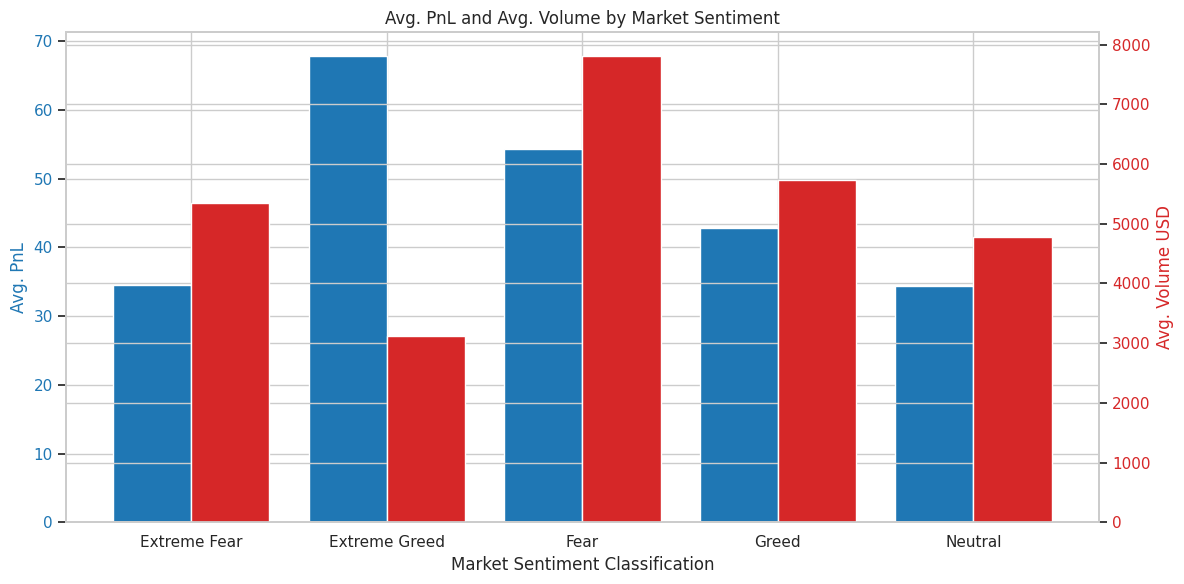

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

x = deeper_insight_on_sentiment_and_pl['classification']
x_pos = range(len(x))

color1 = 'tab:blue'
ax1.set_xlabel('Market Sentiment Classification')
ax1.set_ylabel('Avg. PnL', color=color1)
ax1.bar(x_pos, deeper_insight_on_sentiment_and_pl['avg_pnl'], color=color1, width=0.4, label='Avg. PnL')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Avg. Volume USD', color=color2)
ax2.bar([p + 0.4 for p in x_pos], deeper_insight_on_sentiment_and_pl['avg_volume_usd'], color=color2, width=0.4, label='Avg. Volume')
ax2.tick_params(axis='y', labelcolor=color2)

ax1.set_xticks([p + 0.2 for p in x_pos])
ax1.set_xticklabels(x)

plt.title('Avg. PnL and Avg. Volume by Market Sentiment')

plt.tight_layout()
plt.show()

Summary of analysis:


The negative correlation between value(Market sentiments) and total_pnl total_volume_usd, unique_traders tells that trading participation increases significantly with slight increase in trader performance when market sentiment is more fearful.


The bar chart gives even clear insight of how market sentiment signficantly effects participation and p&l.


key insights:

1. On extreme greed days, average volume traded is the lowest but average profit is the highest

2. On fear days average volume traded is highest but average pnl is average.